# 목표

- 정상적인 사용자와 분산형 크롤러를 구분 가능한지 확인한다.


# 순서

1. 웹 트래픽 데이터를 로드한다.
2. 전반부 N일과 후반부 30-N일을 분리한다.
3. 전반부 N일로 td3 영역을 체크한다. 0회 접근한 아이템 까지 포함한다.
4. 후반부 30-N일 트래픽으로 false positive를 확인한다.
5. 크롤러로 true positive를 확인한다.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [8]:
import anti_crawler as ac

In [9]:
a = ac.AntiCrawl()

Loading access_log_jul95.csv
Removing failed requests..
Adding day column..
Load Complete 1701011 items


# Get long-tail item data frame

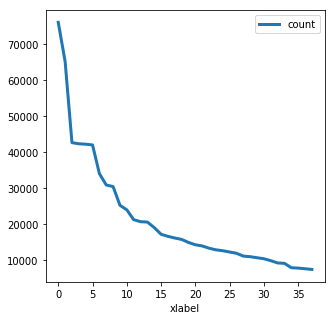

count       38.000000
mean     21250.947368
std      15859.346650
min       7326.000000
25%      10912.750000
50%      15254.000000
75%      24852.750000
max      76040.000000
Name: count, dtype: float64


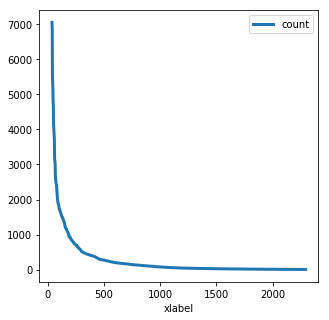

count    2256.000000
mean      264.886082
std       630.802071
min         9.000000
25%        21.000000
50%        53.000000
75%       203.000000
max      7043.000000
Name: count, dtype: float64


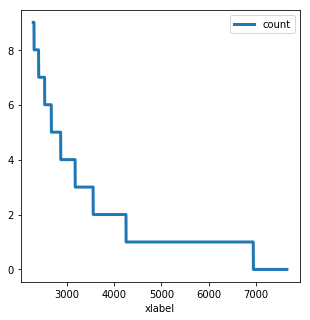

count    5355.000000
mean        1.882353
std         1.860963
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: count, dtype: float64
Count: 5355 / 7649


In [10]:
train_until = 23
td3 = a.get_td3(train_until, _label=[0.005, 0.1, 0.3])

# Simulator Functions
- Crawler Set Node Reducing Simulator
- Web Traffic Node Reducing False Positive Checker

In [115]:
def simulate(crawl_num, df, item_list, threshold, except_item=".gif", _plot=True, _longtail=True):
    result = dict()
    attacker_ip = [x for x in range(crawl_num)]
    server_mem = dict()
    
#     td3_list = df[df['count'] <= threshold]['uri'].values
    if _longtail:
        td3_list = df[df['count'] <= threshold]['uri'].values
    else:
        td3_list = df['uri'].values

    aip = 0
    eliminated = 0
    
    for pos, item in enumerate(item_list):
        laip = len(attacker_ip)
        
        result[pos] = laip
        
        if laip < 1:
            continue
            
        aip = (aip + 1) % laip
        
        if item.lower().endswith(except_item):
            continue
            
        if item not in td3_list:
            continue
            
        atkip = attacker_ip[aip]

        if atkip not in server_mem:
            server_mem[atkip] = [item]
        elif item not in server_mem[atkip]:
            server_mem[atkip].append(item)

        if len(server_mem[atkip]) >  threshold:
            attacker_ip.remove(atkip)      
            if len(attacker_ip) < 1:
                eliminated = pos
    
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        ax = df_result.plot()
        ax.legend(["number of nodes"])
        plt.show()
    
    return laip, eliminated


def simulate_real(df_traffic, df_td3, threshold, banned, except_item=".gif", _plot=False, _longtail=True):
    result = dict()
    server_mem = dict()
    server_mem = dict()
    
    td3_list = df_td3['uri'].values    
#     print("Td3 list len: %d" % len(td3_list))
    
    n = 0
    
    for item in df_traffic.iterrows():
        uri = str(item[1].URI)
        ip = item[1].IP
        
        result[n] = len(banned)
        n += 1
        
        if ip in banned:
            continue
            
        if uri.lower().endswith(except_item):
            continue
        
        if uri not in td3_list:
            continue
            
        if ip not in server_mem:
            server_mem[ip] = [uri]
        elif uri not in server_mem[ip]:
            server_mem[ip].append(uri)
        
        if len(server_mem[ip]) > threshold:
            banned.append(ip)
            
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        df_result.plot()
        plt.show()
    
    return server_mem
        
        

# Simulate Node Reducing

7649
(5355, 5)


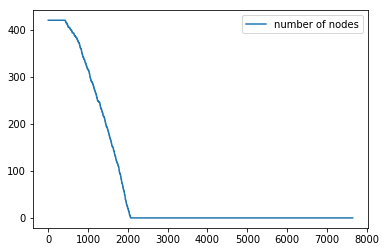

0 2067


In [141]:
threshold = 1
except_item = '.gif'

df_count = a.get_item_count(a.df)

item_list = df_count['uri'].tolist()
random.shuffle(item_list)

print(len(item_list))
print(td3.shape)

result, eliminated = simulate(420, td3, item_list, threshold, except_item=except_item)
print(result, eliminated)


7649
(5355, 5)


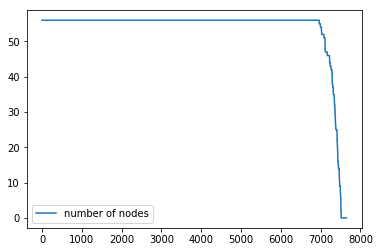

0


In [90]:
# Normal Frequency Based 
threshold = 110
except_item = '.gif'

df_count = a.get_item_count(a.df)

item_list = df_count['uri'].tolist()
random.shuffle(item_list)

print(len(item_list))
print(td3.shape)

result = simulate(56, a.df_tdall, item_list, threshold, except_item=except_item, _longtail=False)
print(result)

In [158]:
def get_detect_limit(_threshold, _df, _items, _except, _longtail=True, _crl_cnt=5):
    result, eliminated = simulate(_crl_cnt, _df, _items, _threshold, _except, _plot=False, _longtail=_longtail)    
    if result == 0:
        ratio = min(len(_items) / eliminated, 3)
        inc = int(_crl_cnt * ratio) - 2
        if inc <= _crl_cnt:
            return _crl_cnt, eliminated
        return get_detect_limit(_threshold, _df, _items, _except, _longtail, _crl_cnt= inc)
    else:
        return get_detect_limit(_threshold, _df, _items, _except, _longtail, _crl_cnt= _crl_cnt-1)

def get_limit_table(_range):
    with open("ltm_detect_limit.csv", 'w', encoding='utf-8') as fo:
        fo.write("THRESHOLD|LIMIT|ELIMATED_POS\n")
        for thold in range(1, _range):
            limit, el = get_detect_limit(thold, td3, item_list, _except=except_item)
            wline = "%d|%d|%d\n" % (thold, limit, el)
            print(wline)
            fo.write(wline)

    with open("frq_detect_limit.csv", 'w', encoding='utf-8') as fo:
        fo.write("THRESHOLD|LIMIT|ELIMATED_POS\n")
        for thold in range(1, _range):
            limit, el = get_detect_limit(thold, a.df_tdall, item_list, _except=except_item, _longtail=False)
            wline = "%d|%d|%d\n" % (thold, limit, el)
            print(wline)
            fo.write(wline)
    
    return True

1|3163|7645

2|2108|7643

3|1581|7643

4|1264|7636

5|1054|7643

6|902|7629

7|789|7626

8|701|7620

9|631|7623

10|573|7612

11|525|7609

12|485|7616

13|450|7609

14|420|7609

15|393|7596

16|370|7598

17|350|7609

18|331|7597

19|314|7588

20|299|7587

21|285|7576

22|273|7587

23|261|7568

24|251|7582

25|241|7570

26|232|7568

27|224|7579

28|216|7568

29|208|7542

30|202|7566

31|195|7542

32|189|7537

33|184|7559

34|178|7527

35|173|7525

36|169|7556

37|164|7529

38|160|7542

39|156|7542

40|152|7529

41|148|7510

42|145|7534

43|141|7498

44|138|7504

45|135|7504

46|132|7498

47|129|7482

48|127|7519

49|124|7493

50|122|7518

51|119|7475

52|117|7494

53|115|7504

54|113|7509

55|111|7510

56|109|7507

57|107|7500

58|105|7486

59|103|7466

60|101|7442

61|100|7493

62|98|7460

63|96|7421

64|95|7461

65|93|7413

66|92|7447

67|91|7475

68|89|7416

69|88|7441

70|87|7463

71|85|7392

72|84|7405

73|83|7419

74|82|7428

75|81|7436

76|80|7441

77|79|7445

78|78|7445

79|77|7

# Simulate Web Traffic with Node Reducing Algorithm

In [14]:
gr_traffic = a.df[a.df.day > (train_until - 1)].groupby('day')

In [114]:
def ltm_fp_test(threshold, gr_traffic, df_item, _long_tail=True, csv_name="day_traffic_fp.csv"):
#     print("Threshold: %d" % threshold)
    banned_list = list()
    total_ip = 0

    for day, df_trf in gr_traffic:  
        serv_mem = simulate_real(df_trf, df_item, threshold, banned_list, except_item=except_item, _longtail=_long_tail)
        day_ip = df_trf['IP'].nunique()
        total_ip += day_ip
        print("Day: %d, Banned: %d" % (day, len(banned_list)))

    banned_sum = len(banned_list)
    fp_rate = banned_sum / total_ip
    result = (threshold, banned_sum, total_ip, fp_rate * 100)
    print("With Threshold: %d, Total Banned: %d in %d IP (%0.5f)%%" % result)
    
    return result

with open("ltm_fp_test.csv", 'w') as fo:
    for n in range(1, 120):
        result = ltm_fp_test(n, gr_traffic, td3)
        fo.write("%d|%d|%d|%0.6f\n" % result)
        
# with open("frq_fp_test.csv", 'w') as fo:
#     for n in range(1, 120):
#         result = ltm_fp_test(n, gr_traffic,  a.df_tdall, _long_tail=False)
#         fo.write("%d|%d|%d|%0.6f\n" % result)


Day: 23, Banned: 47
Day: 24, Banned: 167
Day: 25, Banned: 307
Day: 26, Banned: 401
Day: 27, Banned: 494
Day: 28, Banned: 521
With Threshold: 1, Total Banned: 521 in 21791 IP (2.39090)%
Day: 23, Banned: 31
Day: 24, Banned: 100
Day: 25, Banned: 191
Day: 26, Banned: 242
Day: 27, Banned: 303
Day: 28, Banned: 318
With Threshold: 2, Total Banned: 318 in 21791 IP (1.45932)%
Day: 23, Banned: 20
Day: 24, Banned: 60
Day: 25, Banned: 114
Day: 26, Banned: 142
Day: 27, Banned: 182
Day: 28, Banned: 193
With Threshold: 3, Total Banned: 193 in 21791 IP (0.88569)%
Day: 23, Banned: 12
Day: 24, Banned: 42
Day: 25, Banned: 79
Day: 26, Banned: 102
Day: 27, Banned: 127
Day: 28, Banned: 137
With Threshold: 4, Total Banned: 137 in 21791 IP (0.62870)%
Day: 23, Banned: 7
Day: 24, Banned: 30
Day: 25, Banned: 59
Day: 26, Banned: 80
Day: 27, Banned: 97
Day: 28, Banned: 103
With Threshold: 5, Total Banned: 103 in 21791 IP (0.47267)%
Day: 23, Banned: 4
Day: 24, Banned: 21
Day: 25, Banned: 44
Day: 26, Banned: 57
Day:

Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 48, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 49, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 50, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 51, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 52, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 53, T

Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 95, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 96, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 97, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 98, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 99, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0
Day: 25, Banned: 1
Day: 26, Banned: 1
Day: 27, Banned: 1
Day: 28, Banned: 1
With Threshold: 100, Total Banned: 1 in 21791 IP (0.00459)%
Day: 23, Banned: 0
Day: 24, Banned: 0

KeyboardInterrupt: 

In [82]:
# Normal Frequency Based Anti-Crawling
threshold = 110
print("Threshold: %d" % threshold)
banned_list = list()
banned_sum = 0
total_ip = 0

banned_list = list()
with open("day_traffic_fp.csv", 'w', encoding='utf-8') as fo:
    fo.write("DAY|NUM_TRFC|NUM_BANNED|NUM_IP|FP_RATE|BANNED_LIST\n")
    for day, df_trf in gr_traffic:  
        banned, serv_mem = simulate_real(df_trf, a.df_tdall, threshold, except_item=except_item, _longtail=False)
        banned_list += banned
        num_banned = len(banned)
        num_traffic = df_trf.shape[0]
        
        day_ip = df_trf['IP'].nunique()
        
        if day_ip == 0:
            continue
        
        wline = "%d|%d|%d|%d|%f\n" % (day, num_traffic, num_banned, day_ip, (num_banned / day_ip))
        banned_sum += num_banned
        total_ip += day_ip
        print(wline)
        
        fo.write(wline)
        print("---------------------------")

print("Total Banned: %d in %d IP (%0.5f)%%" % (banned_sum, total_ip, (banned_sum * 100) / total_ip))

Threshold: 110
Td3 list len: 7649
23|36125|1|2575|0.000388

---------------------------
Td3 list len: 7649
24|58183|1|4223|0.000237

---------------------------
Td3 list len: 7649
25|57102|2|4321|0.000463

---------------------------
Td3 list len: 7649
26|53485|0|4224|0.000000

---------------------------
Td3 list len: 7649
27|56107|2|4308|0.000464

---------------------------
Td3 list len: 7649
28|24810|0|2140|0.000000

---------------------------
Total Banned: 6 in 21791 IP (0.02753)%


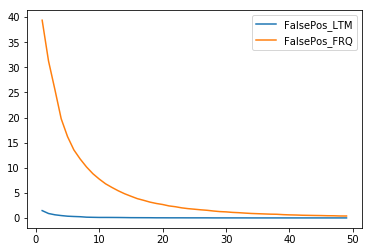

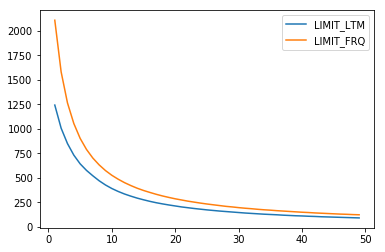

In [184]:
df_ltm_fp = pd.read_csv('ltm_fp_test.csv', sep='|', encoding='utf-8')
df_frq_fp = pd.read_csv('frq_fp_test.csv', sep='|', encoding='utf-8')

df_compare_fp = pd.merge(df_ltm_fp, df_frq_fp, left_on='TD', suffixes=('_LTM', '_FRQ'), right_on='TD')

df_ltm_limit = pd.read_csv('ltm_detect_limit.csv', sep='|', encoding='utf-8')
df_frq_limit = pd.read_csv('frq_detect_limit.csv', sep='|', encoding='utf-8')

df_compare_limit = pd.merge(df_ltm_limit, df_frq_limit, left_on='TD', suffixes=('_LTM', '_FRQ'), right_on='TD')

df_compare = pd.merge(df_compare_fp, df_compare_limit, left_on='TD', suffixes=('_FP', '_LIMIT'), right_on='TD')

df_compare[['FalsePos_LTM', 'FalsePos_FRQ']][1:50].plot()
df_compare[['LIMIT_LTM', 'LIMIT_FRQ']][1:50].plot()
# df_compare

In [17]:
# 전체 차단 IP
banned_list = list(set(banned_list))

print(len(banned_list))
banned_list

1


['jbiagioni.npt.nuwc.navy.mil']

In [18]:
df_day_trfc = pd.read_csv("day_traffic_fp.csv", sep='|', encoding='utf-8')
df_day_trfc

,DAY,NUM_TRFC,NUM_BANNED,NUM_IP,FP_RATE,BANNED_LIST
0,23,36125,0,2575,0.000000,NaN
1,24,58183,0,4223,0.000000,NaN
2,25,57102,1,4321,0.000231,jbiagioni.npt.nuwc.navy.mil
3,26,53485,0,4224,0.000000,NaN
4,27,56107,0,4308,0.000000,NaN
5,28,24810,0,2140,0.000000,NaN


In [19]:
df_day_trfc.describe()

,DAY,NUM_TRFC,NUM_BANNED,NUM_IP,FP_RATE
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,25.500000,47635.333333,0.166667,3631.833333,0.000039
std,1.870829,13858.877309,0.408248,997.472289,0.000094
min,23.000000,24810.000000,0.000000,2140.000000,0.000000
25%,24.250000,40465.000000,0.000000,2987.000000,0.000000
50%,25.500000,54796.000000,0.000000,4223.500000,0.000000
75%,26.750000,56853.250000,0.000000,4287.000000,0.000000
max,28.000000,58183.000000,1.000000,4321.000000,0.000231


In [20]:
gr_ip = a.df.groupby('IP')

In [21]:
for ip, df_ip in gr_ip:
    if ip not in banned_list:
        continue
    
    print("%s: %d" % (ip, df_ip.shape[0]))

jbiagioni.npt.nuwc.navy.mil: 2124


In [22]:
td3['is_td3'] = True
wierd_ip = 'sputnix.cas.und.nodak.edu'
df_tagged = pd.merge(a.df, td3, how='outer', left_on='URI', right_on='uri')[['IP','URI', 'RESULT', 'day', 'is_td3']]
# a.df[(a.df['IP'] == 'jbiagioni.npt.nuwc.navy.mil') & (a.df['day'] > (train_until - 1))]
df_fp_td3 = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1)) & (df_tagged['is_td3'] == True)]
df_fp_all = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1))]

print("%s - td3: %d / all: %d (%f)" % (wierd_ip, df_fp_td3.shape[0], df_fp_all.shape[0], df_fp_td3.shape[0] / df_fp_all.shape[0]))
df_fp_td3

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


sputnix.cas.und.nodak.edu - td3: 30 / all: 101 (0.297030)


,IP,URI,RESULT,day,is_td3
1556556,sputnix.cas.und.nodak.edu,/history/gemini/gemini-xi/,200.0,25,True
1556568,sputnix.cas.und.nodak.edu,/history/gemini/gemini-x/,200.0,25,True
1557196,sputnix.cas.und.nodak.edu,/history/mercury/ma-7/,200.0,25,True
1557219,sputnix.cas.und.nodak.edu,/history/mercury/mr-4/,200.0,25,True
1560700,sputnix.cas.und.nodak.edu,/history/mercury/ma-8/,200.0,25,True
1560731,sputnix.cas.und.nodak.edu,/history/mercury/ma-9/,200.0,25,True
1563570,sputnix.cas.und.nodak.edu,/history/mercury/mr-3/,200.0,25,True
1563590,sputnix.cas.und.nodak.edu,/history/gemini/gemini-v/,200.0,25,True
1569558,sputnix.cas.und.nodak.edu,/history/gemini/gemini-3/,200.0,25,True
1569580,sputnix.cas.und.nodak.edu,/history/gemini/gemini-vii/,200.0,25,True


In [23]:
df_fp_td3['URI'].nunique()

29

In [24]:
def parse_uri(_uri):
    if _uri.endswith('/'):
        return '/'
    
    file_name = _uri.split('/')[-1]
    
    if '.' not in file_name:
        return 'no_ext'
    
    return file_name.split('?')[0].split('.')[-1]

# a.df['ext'] = a.df['URI'].apply(lambda x: parse_uri(x))
df_all = a.get_item_count(a.df[['URI', 'IP', 'day']])
df_all['ext'] = df_all['uri'].apply(lambda x: parse_uri(x))

df_all

,count,uri,ext
0,90110,/images/NASA-logosmall.gif,gif
1,77077,/images/KSC-logosmall.gif,gif
2,53653,/images/MOSAIC-logosmall.gif,gif
3,53249,/images/USA-logosmall.gif,gif
4,52889,/images/WORLD-logosmall.gif,gif
5,52761,/images/ksclogo-medium.gif,gif
6,38436,/ksc.html,html
7,36897,/shuttle/countdown/,/
8,36202,/images/launch-logo.gif,gif
9,30457,/images/ksclogosmall.gif,gif


# Show percentage of long-tail item

In [25]:
df_tagged = pd.merge(df_all, td3, how='outer', left_on='uri', right_on='uri')[['uri', 'is_td3', 'ext']]
df_tagged = df_tagged.fillna(False)

gr_ext = df_tagged.groupby('ext')

def sort_func(x):
    return x[1].shape[0]

gr_ext = sorted(gr_ext, key=lambda x: sort_func(x), reverse=True)

for ext, df_ext in gr_ext:
    num_true = df_ext[df_ext['is_td3'] == True].shape[0]
    num_false = df_ext[df_ext['is_td3'] == False].shape[0]
    num_total = num_true + num_false
    print("%s: %d / %d (%0.f %%)" % (ext, num_true, num_total, num_true * 100 / num_total))

pl: 2388 / 2476 (96 %)
gif: 441 / 983 (45 %)
/: 458 / 788 (58 %)
html: 267 / 744 (36 %)
txt: 366 / 617 (59 %)
no_ext: 472 / 484 (98 %)
jpg: 98 / 364 (27 %)
GIF: 206 / 333 (62 %)
htm: 91 / 179 (51 %)
gif": 144 / 159 (91 %)
html": 72 / 80 (90 %)
mpg: 17 / 62 (27 %)
GIF": 47 / 48 (98 %)
jpg": 47 / 47 (100 %)
txt": 26 / 26 (100 %)
jpeg: 18 / 23 (78 %)
ksc: 23 / 23 (100 %)
mpg": 19 / 19 (100 %)
JPG: 12 / 18 (67 %)
pdf: 13 / 16 (81 %)
perl: 11 / 15 (73 %)
92: 14 / 14 (100 %)
wav: 5 / 10 (50 %)
91: 9 / 9 (100 %)
93: 9 / 9 (100 %)
bps: 8 / 8 (100 %)
xbm: 0 / 8 (0 %)
90: 7 / 7 (100 %)
bak: 4 / 5 (80 %)
eps: 4 / 5 (80 %)
wav": 4 / 5 (80 %)
xbm": 5 / 5 (100 %)
89: 4 / 4 (100 %)
bmp: 0 / 3 (0 %)
cgi: 3 / 3 (100 %)
htm": 3 / 3 (100 %)
map: 2 / 3 (67 %)
pl": 2 / 3 (67 %)
zip: 3 / 3 (100 %)
WAV: 0 / 2 (0 %)
art: 1 / 2 (50 %)
bash_history: 2 / 2 (100 %)
com: 1 / 2 (50 %)
doc: 2 / 2 (100 %)
good: 2 / 2 (100 %)
jpl: 2 / 2 (100 %)
txt~: 1 / 2 (50 %)
%24%24%24: 1 / 1 (100 %)
2: 1 / 1 (100 %)
bad: 1 / 1 (1